### CPSC 672 Network Project

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import spatial
import csv
import collections as ct
from tqdm.notebook import tqdm
import re
%run AdditionalClasses/NullCompare.ipynb import *
%run AdditionalClasses/GraphFromFile.ipynb import *
%run AdditionalClasses/NetworkMeasures.ipynb import *
%matplotlib inline

### Data

The following few cells read in our data from a excel spreadsheet and organize them into a few arrays:
- stock_symbols contains all the actual stock names
- dates contains all the column headings (which are dates) from Feb 2010 to Dec 2021

In [2]:
df_total = pd.read_excel('data/all_data.xlsx', sheet_name='percentChange',engine='openpyxl')

In [3]:
stock_symbols = []
for stock in df_total['Stock']:
    stock_symbols.append(stock)

dates = df_total.columns.values
dates = dates[2:]

### Calculating links

To get the links between any two stocks, we use cosine similarity to determine how correlated two stocks are. The formula for cosine similarity is as follows:
$$ 
x = {1 - \frac{u \cdot v}{||u|| * ||v||}  }
$$
                            
the getSimilarities() functions do just that by comparing every stock, with every other stock, for any input date (column). Note one of the functions calculates this over a 12 month period (Yearly) whereas the other function uses the total dataset.

In [6]:
def getSimilaritiesTotal(dataFrame):
    similarities = []
    for i in tqdm(range(len(dataFrame))):
        for j in range(i+1,len(dataFrame)):
            first_stock = dataFrame.iloc[i,2:]
            second_stock = dataFrame.iloc[j,2:]
            result = 1 - spatial.distance.cosine(first_stock,second_stock)
            similarities.append((stock_symbols[i], stock_symbols[j], result))
    return similarities

In [7]:
def getSimilaritiesYearly(date,dataFrame):
    similarities = []
    elems = len(dataFrame[date])
    start_col = (np.where(dates == date)[0][0]) + 2 # plus 2 is for indexing away from stock symbol & sector
    end_col = start_col + 12
    for i in tqdm(range(elems)):
        for j in range(i+1,elems):
            first_stock = dataFrame.iloc[i,start_col:end_col]
            second_stock = dataFrame.iloc[j,start_col:end_col]
            result = 1-spatial.distance.cosine(first_stock,second_stock)
            similarities.append((stock_symbols[i], stock_symbols[j], result))
    return similarities

In [8]:
def getAllYears(dataFrame):
    i = 0
    arr = []
    start_date = dates[i]
    curr_year = start_date.year
    while(curr_year < 2021):
        yearly_similarity = getSimilaritiesYearly(start_date,dataFrame)
        arr.append((start_date,yearly_similarity))
        curr_year+=1
        i+=12
        start_date = dates[i]
    return arr

### Getting the total and Yearly similarities

In [ ]:
total_similarities = getSimilaritiesTotal(df_total)

In [ ]:
yearly_similarites = getAllYears(df_total)

### Exporting
At this point all the stock symbols are exported to csv files, each year has it's own specific set of links. And there is also a csv that contains the total similarity across the entire dataset

In [20]:
def writeStocks():
    sectors = pd.read_excel("data/all_data.xlsx",sheet_name='percentChange',engine='openpyxl')
    sectors = sectors[["Stock","Sector"]]
    with open('data/stocks.csv','w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID\tlabel\tsector"])
        for stock in stock_symbols:
            sect = ((sectors.loc[sectors["Stock"] == stock]["Sector"]).to_string(index=False)).replace(" ","")
            sect = re.sub('[^a-zA-Z]+', '', sect)
            idx  = str(stock_symbols.index(stock))
            writer.writerow([idx+"\t"+stock+"\t"+sect])

In [5]:
def writeTotal(threshold):
    with open('data/Raw_links/links_total.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Source	Target	Weight"])
        for link in total_similarities:
            first_stock_index = str(stock_symbols.index(link[0]))
            second_stock_index = str(stock_symbols.index(link[1]))
            link_weight = link[2]
            if(abs(link_weight) > threshold):
                writer.writerow([first_stock_index+"\t"+second_stock_index+"\t"+str(link_weight)])

In [6]:
def writeYearly(yearly_calc,threshold):
    for year in yearly_calc:
        curr_year = year[0].year
        links = year[1]
        file_name = 'data/Raw_links/links_'+str(curr_year)+'.csv'
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Source	Target	Weight"])
            for link in links:
                first_stock_index = str(stock_symbols.index(link[0]))
                second_stock_index = str(stock_symbols.index(link[1]))
                link_weight = link[2]
                if(abs(link_weight) > threshold):
                    writer.writerow([first_stock_index+"\t"+second_stock_index+"\t"+str(link_weight)])

In [21]:
writeStocks()
#writeTotal(0.5)

In [ ]:
writeYearly(yearly_similarites,0.6)

### Visualizing the Data
Now that the data has been processed and exported into their own csv's , we can begin to do some visualiation and more graph theory related calculations.
Also, due to lack of computational resources, we have decided to reduce the number of links to 100,000 . The following two functions take the original csv's and take the strongest 100,000 links and save them. Links who do not make the cut are simply discarded.

In [11]:
def filterYearly(num_of_links):
    for i in range(2010,2021):
        df_link=pd.read_csv("data/Raw_links_"+str(i)+".csv",delimiter="\t")
        df_link = df_link.sort_values(by=['Weight'],key=abs,ascending=False,ignore_index=True)
        df_link[:num_of_links].to_csv("data/Filtered_links/links_"+str(i)+".csv",sep='\t',index=False)

In [12]:
def filterTotal(num_of_links):
        df_link=pd.read_csv("data/Raw_links_total.csv",delimiter="\t")
        df_link = df_link.sort_values(by=['Weight'],key=abs,ascending=False,ignore_index=True)
        df_link[:num_of_links].to_csv("data/Filtered_links/links_total.csv",sep="\t",index=False)

In [ ]:
filterYearly(100000)
filterTotal(100000)

In [26]:
Yearly_Graphs = []
for i in range(2010,2021):
    G =GraphFromFile().GraphFromFileYearlyAbsWeights(i)
    Yearly_Graphs.append(G)

In [27]:
Total_Graph = []
Total_Graph.append(GraphFromFile().GraphFromFileTotalAbsWeights())

In [28]:
'''
Source code obtained from:
Author: Emma Towlson
https://d2l.ucalgary.ca/d2l/le/content/472066/viewContent/5526868/View

Modifications have been made from the original to fit our problem set
'''
def PlotGraphDegDistribution(Graph_list):
    fig = plt.figure(figsize=(6,4))
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    for i in range(len(Graph_list)):
        G = Graph_list[i]
        N = len(G)
        L = G.size()
        degrees = [G.degree(node,weight='weight') for node in G]
        kmin = min(degrees)
        kmax = max(degrees)

        # Get 10 logarithmically spaced bins between kmin and kmax
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=20)

        # histogram the data into these bins
        density, _ = np.histogram(degrees, bins=bin_edges, density=True)


        # "x" should be midpoint (IN LOG SPACE) of each bin
        log_be = np.log10(bin_edges)
        x = 10**((log_be[1:] + log_be[:-1])/2)
        label = 2010 +i if len(Graph_list) > 1 else "total"
        plt.loglog(x, density, marker='o', label = label,linestyle='none')


        # remove right and top boundaries because they're ugly
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        # Show the plot
    plt.legend()
    plt.show()

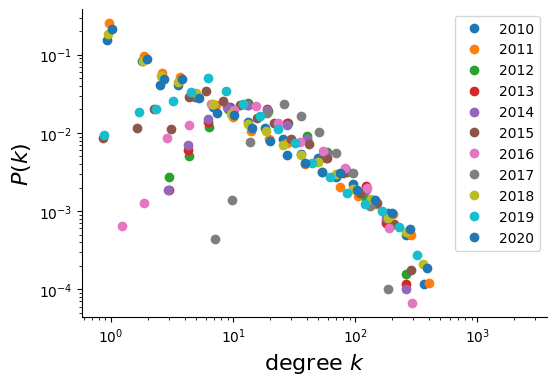

In [29]:
PlotGraphDegDistribution(Yearly_Graphs)           #for ploting total graph degree distribution

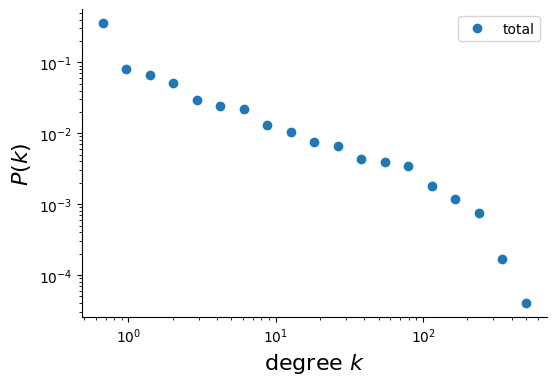

In [30]:
PlotGraphDegDistribution(Total_Graph)             #for ploting total graph degree distribution

In [7]:
G = Total_Graph[0]
CG = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(CG[0])                 # select the biggest connected component

In [8]:
n = NullCompare(G)

In [9]:
C,d = n.CalculateStats()
print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

Average Clustering Coefficient:  0.6678847956398628
Average Shortest Path:  2.728443762372391


In [ ]:
clustering_ER,short_path_ER = n.ERStats(1000)
print(np.mean(clustering_ER))
print(np.std(clustering_ER))

print(np.mean(short_path_ER))
print(np.std(short_path_ER))

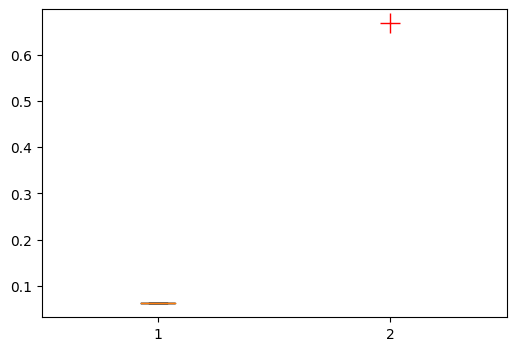

In [13]:
n.ClusteringCoffPlot(clustering_ER,C )

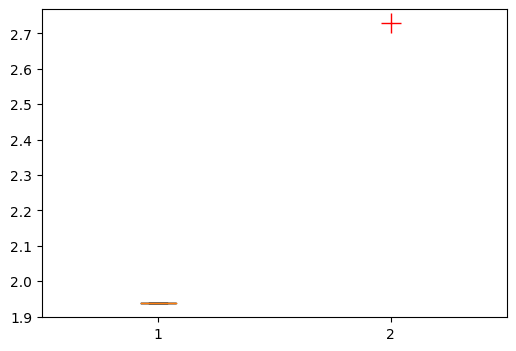

In [14]:
n.ShortPathPlot(short_path_ER,d)

In [ ]:
clustering_DP,short_path_DP = n.DPStats(1000)
print(np.mean(clustering_DP))
print(np.std(clustering_DP))

print(np.mean(short_path_DP))
print(np.std(short_path_DP))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8


In [59]:
G = GraphFromFile().GraphFromFileTotalAbsWeights()

In [60]:
Measure = NetworkMeasures(G)
#Measure.SectorStats()

In [61]:
result = Measure.EigenvectorCentrality(Top= True)
print(result)

RVT Sector ETF
TY Sector ETF
GDV Sector ETF
EVT Sector ETF
RMT Sector ETF
CSQ Sector ETF
USA Sector ETF
GAM Sector ETF
ETG Sector ETF
ETO Sector ETF
AVK Sector ETF
BTO Sector Metals & Mining
CHW Sector ETF
MCN Sector ETF
SCD Sector ETF
FFA Sector ETF
LNC Sector Insurance
GAB Sector ETF
LGI Sector ETF
BDJ Sector ETF
ETY Sector ETF
PFG Sector Insurance
PH Sector Machinery
EXG Sector ETF
NFJ Sector ETF
EMR Sector Electrical Equipment
WCC Sector Trading Companies & Distributors
NIE Sector ETF
PEO Sector ETF
GL Sector Insurance
PRU Sector Insurance
HON Sector Industrial Conglomerates
C Sector Banks
AMP Sector Capital Markets
MET Sector Insurance
CR Sector Machinery
CET Sector Asset Management
ADX Sector ETF
DDF Sector ETF
RTX Sector Aerospace & Defense
EWBC Sector Banks
SLB Sector Energy Equipment & Services
FLS Sector Machinery
FUL Sector Chemicals
CHI Sector ETF
GLQ Sector ETF
ASG Sector ETF
SPXX Sector ETF
CII Sector ETF
ASB Sector Banks
AOD Sector ETF
CATY Sector Banks
EMN Sector Chemic

In [62]:
Measure.SectorFraction(result)

[('ETF', 0.15460526315789475), ('Insurance', 0.09333333333333334), ('Trading Companies & Distributors', 0.08), ('Consumer Finance', 0.06666666666666667), ('Machinery', 0.05813953488372093), ('Capital Markets', 0.05263157894736842), ('Banks', 0.05179282868525897), ('Auto Components', 0.047619047619047616), ('Real Estate Management & Development', 0.043478260869565216), ('Equity Real Estate Investment Trusts ...', 0.04081632653061224), ('Hotels, Restaurants & Leisure', 0.0392156862745098), ('Electronic Equipment, Instruments & C...', 0.038461538461538464), ('Chemicals', 0.038461538461538464), ('Electrical Equipment', 0.03571428571428571), ('Professional Services', 0.02857142857142857), ('Aerospace & Defense', 0.02702702702702703), ('Energy Equipment & Services', 0.02631578947368421), ('Metals & Mining', 0.009433962264150943)]


In [63]:
G = GraphFromFile().GraphFromFileTotalAbsWeights()

gamma=  1.2802636927483235


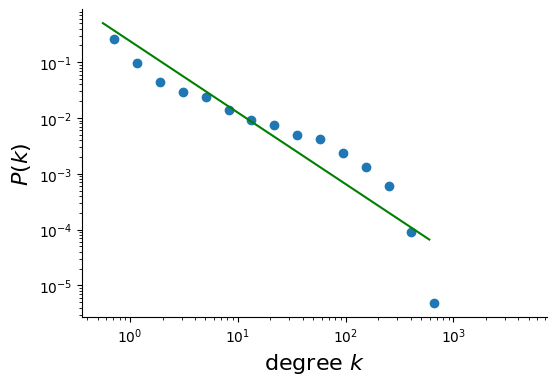

In [64]:
NullCompare(G).plot_degree_dist_and_fit()

In [34]:
G = GraphFromFile().GraphFromFileTotalWeights()
C = np.mean([G.degree(n) for n in G.nodes()])
print(C)

[3, 3, 10, 9, 85, 95, 13, 12, 7, 5, 237, 210, 1, 1, 390, 339, 501, 702, 368, 436, 458, 425, 403, 425, 768, 901, 204, 112, 38, 10, 557, 551, 177, 160, 38, 11, 27, 27, 646, 744, 683, 694, 90, 75, 195, 106, 103, 831, 800, 759, 596, 599, 354, 271, 37, 42, 215, 202, 6, 5, 404, 533, 328, 311, 255, 245, 551, 279, 288, 69, 78, 39, 93, 62, 430, 101, 101, 47, 51, 293, 128, 68, 52, 105, 105, 31, 30, 100, 100, 402, 168, 170, 100, 100, 160, 9, 9, 722, 51, 413, 462, 631, 102, 83, 45, 533, 8, 411, 163, 422, 99, 117, 425, 387, 1, 1, 570, 119, 119, 233, 253, 424, 237, 441, 415, 163, 442, 374, 18, 15, 364, 88, 88, 329, 480, 330, 280, 3, 1, 273, 51, 51, 604, 519, 449, 343, 229, 140, 506, 63, 32, 43, 341, 647, 5, 101, 100, 105, 81, 125, 396, 470, 424, 101, 356, 614, 103, 3, 3, 450, 276, 196, 102, 106, 17, 100, 329, 141, 144, 474, 315, 195, 141, 444, 571, 432, 246, 209, 441, 16, 44, 216, 159, 213, 430, 304, 412, 34, 100, 271, 330, 101, 272, 239, 111, 226, 374, 655, 162, 432, 334, 345, 106, 207, 187, 365, 2

In [22]:
CG = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(CG[0])
print(nx.average_shortest_path_length(G,weight=None))

KeyboardInterrupt: 

In [ ]:
C = np.mean(list(nx.clustering(G,weight=None).values()))
print(C)